In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import pygame
from robot_simulation import CrawlingRobotSimulator

In [12]:
class CrawlingRobotEnvironment:
    def __init__(self, goal_x=100, robot_friction=0.1):
        self.eps = 0.01
        self.sim = CrawlingRobotSimulator()
        self.sim.init()
        self.sim.body_shape.friction = robot_friction
        self.possible_actions = [0, 1, 2, 3]
        self.state_bins = [
            np.linspace(self.sim.min_hand_angle, self.sim.max_hand_angle, 10),
            np.linspace(self.sim.min_arm_angle, self.sim.max_arm_angle, 10),
        ]
        self.num_actions = len(self.possible_actions)
        self.num_states = self.state_bins[0].shape + self.state_bins[1].shape
        self.goal_x = goal_x
        self.t_input = 100 # how much time passed after last input was taken.
        
    def reset(self):
        self.sim.reset_bodies(self.sim.bodyXY)
        _, handAngle, armAngle = self.sim.get_states()
        return handAngle, armAngle
    
    def step(self, action, render=False):
        reward = 0
        done = False
        x_old, _, _ = self.sim.get_states()
        
        # handle actions
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
        motor_hand = self.sim.motor_hand
        motor_arm = self.sim.motor_arm
        
        if action == 0: # hand
            new_angle = motor_hand.angle() + np.deg2rad(20)
            motor_hand.set_target_angle(new_angle)
            pass
        elif action == 1: # hand
            new_angle = motor_hand.angle() - np.deg2rad(20)
            motor_hand.set_target_angle(new_angle)
            pass
        elif action == 2: # arm
            new_angle = motor_arm.angle() - np.deg2rad(10)
            motor_arm.set_target_angle(new_angle)
        elif action == 3: # arm
            new_angle = motor_arm.angle() + np.deg2rad(10)
            motor_arm.set_target_angle(new_angle)
        else:
            motor_hand.rate = 0
            motor_arm.rate = 0
            
        while True:
            for motor in self.sim.motor_list:
                motor.update()
            self.sim.update_simulation()
            if render:
                self.render()
            _, handAngle, armAngle = self.sim.get_states()
            if abs(handAngle - motor_hand.target_angle) < self.eps and abs(armAngle - motor_arm.target_angle) < self.eps:
                break

        # reward.
        x, handAngle, armAngle = self.sim.get_states()
        observation = (handAngle, armAngle)
        
        reward += (x-x_old)

        if x < -20:
            done = True
        elif x > self.goal_x:
            done = True
        return observation, reward, done
    
    def render(self):
        self.sim.draw()

class QAgent:
    def __init__(
        self, 
        env: CrawlingRobotEnvironment,
        num_episodes=500,
        learning_rate=0.1,
        discount_factor=0.999,
        epsilon=1,
        min_epsilon = 0.1,
        epsilon_decay=0.9995
        ):
        self.num_episodes = num_episodes
        self.learning_rate = learning_rate
        self.discount_factor =discount_factor
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.possible_actions = env.possible_actions
        self.state_bins = env.state_bins
        # initialze Qtable as all zeros.
        self.Qtable = np.zeros(env.num_states + (env.num_actions, ))
    
    def choose_action(self, state, greedy=False):
        if np.random.rand() < self.epsilon and not greedy:
            action = np.random.choice(self.possible_actions)
        else:
            state_index = self.discretize_state(state)
            action = self.possible_actions[np.argmax(self.Qtable[state_index])]
        return action

    def update_q_value(self, state, action, reward, next_state):
        state_index = self.discretize_state(state)
        next_state_index = self.discretize_state(next_state)
        action_index = self.possible_actions.index(action)
        future_reward = np.max(self.Qtable[next_state_index])
        current_q = self.Qtable[state_index][action_index]
        self.Qtable[state_index][action_index] = current_q + self.learning_rate * (reward + self.discount_factor * future_reward - current_q)
        
    def discretize_state(self, state, hysteresis_margin=0.05):
        """Discretize state with a hysteresis margin to stabilize transitions."""
        arm_value = state[0]
        hand_value = state[1]
        arm_idx = np.digitize(arm_value, [x - hysteresis_margin for x in self.state_bins[0]]) - 1
        hand_idx = np.digitize(hand_value, [x - hysteresis_margin for x in self.state_bins[1]]) - 1
        return arm_idx, hand_idx

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)    

In [13]:
def train(fric):
    pygame.font.init()
    my_font = pygame.font.SysFont('Comic Sans MS', 20)
    env = CrawlingRobotEnvironment(goal_x=200, robot_friction=fric)
    agent = QAgent(env, num_episodes=20, learning_rate=0.1, discount_factor=0.99, epsilon_decay=0.85)
    rewards = []
    try:
        for episode in range(1,agent.num_episodes+1):
            state = env.reset()
            done = False
            cumulative_reward = 0
            while not done:
                action = agent.choose_action(state)            
                new_state, reward, done = env.step(action, render=False)
                agent.update_q_value(state, action, reward, new_state)
                state = new_state
                cumulative_reward += reward
                
            agent.decay_epsilon()

            rewards.append(cumulative_reward)
            print(f'{episode}... eps {agent.epsilon:.2f}, reward {cumulative_reward}')
            if episode % 100 == 0:
                print(episode, cumulative_reward, agent.epsilon)
    finally:
        pygame.quit()
    return agent

def record(agent, fric, max_steps=1000):
    frames = []
    env = CrawlingRobotEnvironment(goal_x=400, robot_friction=fric)
    state = env.reset()
    done = False
    while not done:
        if len(frames) > max_steps:
            break
        action = agent.choose_action(state, greedy=True)
        new_state, reward, done = env.step(action, render=True)
        state = new_state
        print('frame ', len(frames), agent.discretize_state(state))

        # Capture the current frame
        frame_shape = (env.sim.display_size[1], env.sim.display_size[0], 3)
        raw_data = pygame.image.tostring(env.sim.screen, "RGB")
        img = np.frombuffer(raw_data, dtype=np.uint8)
        img = img.reshape(frame_shape)
        frames.append(img)
    return frames

In [14]:
import os
if not os.path.exists('animate'):
    os.mkdir('animate')

In [15]:
robot_frictions = [0.05, 0.5]
# robot_frictions = [0.7]
for fric in robot_frictions:
    for i in range(2, 2+1):
        file_name = f'animate/crawlingRobot_fric{fric}_{i}.mp4'
        print(f'\nStarting simulation for: {file_name} ...........\n')
        agent = train(fric)
        try: 
            frames = record(agent, fric)
        finally:
            imageio.mimwrite(file_name, frames, fps=16)
            pygame.quit()


Starting simulation for: animate/crawlingRobot_fric0.05_2.mp4 ...........

body position
Vec2d(20.0, 120.0)
1... eps 0.85, reward -40.16920692734185
2... eps 0.72, reward -42.19366250043025
3... eps 0.61, reward -41.1782779882804
4... eps 0.52, reward -42.691204724830065
5... eps 0.44, reward 184.13242912621178
6... eps 0.38, reward 183.43121999652385
7... eps 0.32, reward 181.7451170444731
8... eps 0.27, reward 185.55110565217817
9... eps 0.23, reward 180.98828339055518
10... eps 0.20, reward 180.17065691475315
11... eps 0.17, reward 180.61495162013347
12... eps 0.14, reward 185.70352212566223
13... eps 0.12, reward 185.1641164654724
14... eps 0.10, reward 181.1782823745901
15... eps 0.10, reward 181.11567796877335
16... eps 0.10, reward 182.1250084436732
17... eps 0.10, reward 184.46329854713892
18... eps 0.10, reward 181.63805174830054
19... eps 0.10, reward 183.519003858677
20... eps 0.10, reward 184.74744344276462
body position
Vec2d(20.0, 120.0)
frame  0 (9, 1)
frame  1 (7, 1)
f

NameError: name 'frames' is not defined

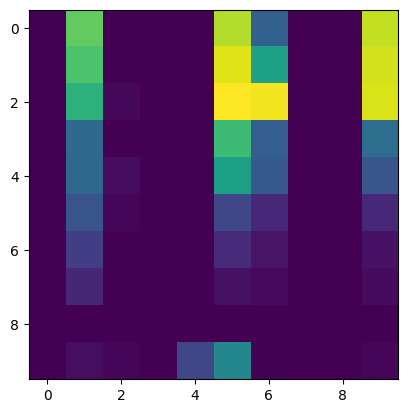

In [ ]:
plt.imshow(agent.Qtable.max(axis=2), )